## Kalman Filter Model

The Kalman filter model assumes the true state at time $k$ is evolved from the state at $k-1$ according to:

$$
\mathbf{x}_k = \mathbf{F}_k \mathbf{x}_{k-1} + \mathbf{B}_k \mathbf{u}_k + \mathbf{w}_k
$$

### Where:
- $\mathbf{F}_k$ is the **state transition model**, which is applied to the previous state $\mathbf{x}_{k-1}$;
- $\mathbf{B}_k$ is the **control-input model**, which is applied to the control vector $\mathbf{u}_k$;
- $\mathbf{w}_k$ is the **process noise**, which is assumed to be drawn from a zero mean **multivariate normal distribution** $\mathcal{N}$, with **covariance** $\mathbf{Q}_k$:
  $$
  \mathbf{w}_k \sim \mathcal{N}(\mathbf{0}, \mathbf{Q}_k).
  $$
At time $k$, an observation (or measurement) $\mathbf{z}_k$ of the true state $\mathbf{x}_k$ is made according to:
$$
\mathbf{z}_k = \mathbf{H}_k \mathbf{x}_k + \mathbf{v}_k
$$

### Where:
- $\mathbf{H}_k$ is the **observation model**, which maps the true state space into the observed space;
- $\mathbf{v}_k$ is the **observation noise**, which is assumed to be zero mean **Gaussian white noise** with **covariance** $\mathbf{R}_k$:
  $$
  \mathbf{v}_k \sim \mathcal{N}(\mathbf{0}, \mathbf{R}_k).
  $$
___

### Predict: 
$$\hat{x}_{k|k-1} = F_{k}\hat{x}_{k-1|k-1} + B_ku_k$$
$$P_{k|k-1} = F_{k}P_{k-1|k-1}F_{k}^T + Q_k$$
### Update: 
* Innovation:
$$\tilde{y}_k = z_k - H\hat{x}_{k|k-1}$$
* Innovation covariance: 
$$S_k = H_kP_{k|k-1}H_k^T + R_k$$
* Optimal Kalman gain: 
$$K_k = P_{k|k-1}H_k^TS_k^{-1}$$
* Updated state estimate:
$$\hat{\mathbf{x}}_{k \mid k} = \hat{\mathbf{x}}_{k \mid k-1} + \mathbf{K}_k \tilde{\mathbf{y}}_k$$
* Updated estimate covariance:
$$P_{k|k} = (I - K_kH_k)P_{k|k-1}$$






In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math 
import sympy as sp

# Kalman filter implementation without library

In [2]:
class Kalman_filter: 
    def __init__(self, F, Q, H, R, x, P, dt, B = None, u = None,):
        self.F = F                                          # transition matrix
        self.B = B if B is not None else np.zeros_like(x)   # control input matrix
        self.u = u if u is not None else np.zeros_like(x)   # control input
        self.Q = Q                                          # motion noise covariance
        self.H = H                                          # observation matrix 
        self.R = R                                          # measurement noise covariance 
        self.x = x                                          # initial state
        self.P = P                                          # error estimate covariance 
        self.dt = dt
        self.I = np.eye(len(self.x))
        self.state_history = [self.x]
    def predict(self): 
        self.x = self.F @ self.x 
        self.P = self.F @ self.P @ self.F.T + self.Q 
    def update(self, z): 
        S = self.H @ self.P @ self.H.T + self.R  # Innovation covariance
        K = self.P @ self.H.T @ np.linalg.inv(S) # Kalman gain
        y = z - self.H @ self.x                  # Innovation
        self.x = self.x + K @ y
        self.P = (self.I - K @ self.H) @ self.P
        self.state_history.append(self.x.copy())

### Wiener-Process Acceleration Noise Model
Assuming that the highest-order term is modeled as a Wiener process with covariance $S_w$. In our case, let assume the highest-order term is acceleration. Then 
$$G = \begin{bmatrix}
0\\
0\\
1
\end{bmatrix}$$
maps the noise into the acceleration state.
Then Q can be calculated: 
$$ Q = \int_0^T \Phi(\tau) G G^\top \Phi^\top(\tau) \, d\tau, $$
Given the transition matrix F: 
$$
F  = 
\begin{bmatrix}
1 & \Delta T & \frac{\Delta T^2}{2} \\
0 & 1 & \Delta T \\
0 & 0 & 1
\end{bmatrix}.
$$
Subsituting F into the equation above yeilds: 
$$
Q= S_w 
\begin{bmatrix}
\frac{\Delta T^5}{20} & \frac{\Delta T^4}{8} & \frac{\Delta T^3}{6} \\
\frac{\Delta T^4}{8} & \frac{\Delta T^3}{3} & \frac{\Delta T^2}{2} \\
\frac{\Delta T^3}{6} & \frac{\Delta T^2}{2} & \Delta T
\end{bmatrix}.
$$

In [3]:
# Test the white noise model: 
from filterpy.common import Q_continuous_white_noise

In [4]:
dt = 0.1
s_w = 1 
Q_ = s_w * np.array([
    [dt**5 / 20, dt**4 / 8, dt**3 / 6],
    [dt**4 / 8, dt**3 / 3, dt**2 / 2],
    [dt**3 / 6, dt**2 / 2, dt]
])
print(Q_)
Q = Q_continuous_white_noise(dim = 3, dt = dt, spectral_density = s_w) 
print(Q)

[[5.00000000e-07 1.25000000e-05 1.66666667e-04]
 [1.25000000e-05 3.33333333e-04 5.00000000e-03]
 [1.66666667e-04 5.00000000e-03 1.00000000e-01]]
[[5.00000000e-07 1.25000000e-05 1.66666667e-04]
 [1.25000000e-05 3.33333333e-04 5.00000000e-03]
 [1.66666667e-04 5.00000000e-03 1.00000000e-01]]


In [5]:
# Test with 1D constant acceleration model 
F = np.array([[1, dt, dt**2/2], [0, 1, dt], [0, 0, 1]]) 
H = np.array([[1, 0, 0]]) 
R = np.array([[1]])
x = np.array([0, 1, 1]).T 
P = np.array([[500, 0, 0],[0, 500, 0], [0, 0, 500]])
v1 = Kalman_filter(F, Q, H, R, x, P, dt)  

In [6]:
# Simulate measurement model: 
class sensor(): 
    def __init__(self, x, v, a, dt, noise_std=1): 
        self.x = x
        self.v = v
        self.a = a
        self.dt = dt 
        self.noise_std = noise_std
    def read(self): 
        self.v += self.a * self.dt
        self.x += self.v * self.dt 
        return self.x + np.random.rand() * self.noise_std

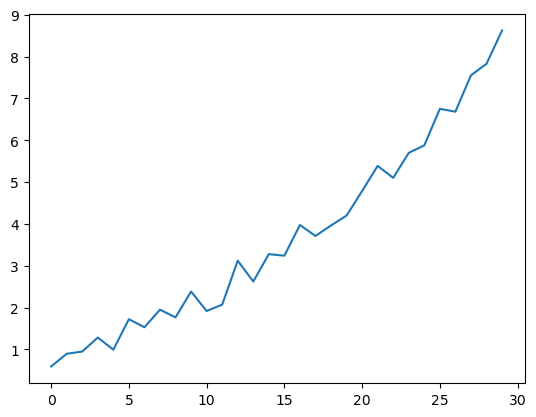

In [7]:
s = sensor(0, 1, 1, 0.1, 1) 
zx = []
for i in range (30): 
    z = s.read() 
    zx.append(z) 
plt.plot(zx) # Should be a parabola

In [8]:
for i in range (30): 
    v1.predict()
    v1.update(zx[i]) 

In [9]:
x_estimate = np.array(v1.state_history)
x_estimate[:, 0]

array([0.        , 0.59257148, 0.87075491, 0.98883096, 1.25222109,
       1.17068131, 1.54783515, 1.6249321 , 1.8881959 , 1.90293484,
       2.23700719, 2.15600699, 2.16082663, 2.67533215, 2.75387992,
       3.08463782, 3.27395093, 3.69209802, 3.86250648, 4.05937368,
       4.26952678, 4.61482076, 5.06139504, 5.2857631 , 5.62903894,
       5.92968922, 6.40949419, 6.74703054, 7.24439959, 7.69809721,
       8.2610665 ])

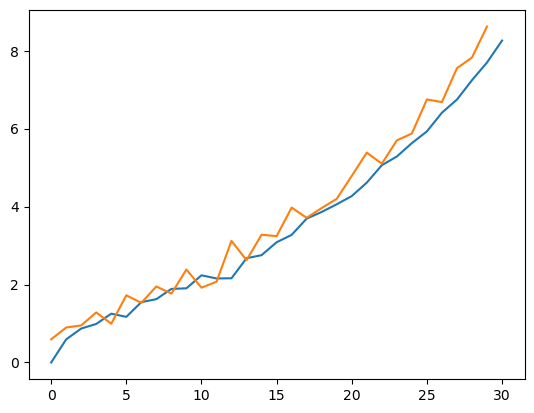

In [10]:
plt.plot(x_estimate[:, 0])
plt.plot(zx)

# Implementation using FilterPy

In [11]:
# Using FilterPy
import filterpy 
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_continuous_white_noise
from filterpy.stats import plot_covariance_ellipse
from scipy.linalg import block_diag

In [12]:
class PosSensor():
    def __init__(self, dt, pos=[0,0], vel=[0, 0], noise_std=1): 
        self.vel = vel
        self.pos = pos 
        self.noise_std = noise_std
        self.dt = dt
    
    def read(self): 
        self.pos[0] += self.vel[0]*self.dt
        self.pos[1] += self.vel[1]*self.dt
        return [self.pos[0] + np.random.randn() * self.noise_std, 
                self.pos[1] + np.random.randn() * self.noise_std]
R_std = 0.35
def tracker1(dt, s_w): 
    tracker = KalmanFilter(dim_x = 4, dim_z = 2) 
    tracker.F = np.array([[1, dt, 0, 0], 
                        [0, 1, 0, 0], 
                        [0, 0, 1, dt], 
                         [0, 0, 0, 1]])
    q = Q_continuous_white_noise(dim = 2, dt = dt, spectral_density = s_w)
    tracker.Q = np.array(block_diag(q, q))
    tracker.u = 0.
    tracker.H = np.array([[1, 0, 0, 0], [0, 0, 1, 0]])
    tracker.R = R = np.array([[R_std **2, 0], [0, R_std**2]])
    tracker.x = np.array([0, 0, 0, 0]).T
    tracker.P = np.eye(4)*500.
    return tracker

In [13]:
N = 100
sensor = PosSensor(dt, [0, 0], [2, 1], noise_std = R_std) 
zs = np.array([sensor.read() for _ in range(N)])

In [14]:
dt = 0.1
s_w = 1
t = tracker1(dt, s_w)

In [15]:
mu, cov, _, _ = t.batch_filter(zs) 

In [16]:
zs.shape

(100, 2)

In [17]:
mu

array([[-5.26725105e-02, -5.21561812e-03,  5.28032503e-02,
         5.22856394e-03],
       [ 4.63707766e-01,  5.03804098e+00,  2.88355833e-01,
         2.29834329e+00],
       [ 9.25470703e-01,  4.78675649e+00,  5.01248448e-01,
         2.19708087e+00],
       [ 8.75746541e-01,  2.51249723e+00,  3.76063876e-01,
         7.12645583e-01],
       [ 1.38184682e+00,  3.37677196e+00,  2.05827525e-01,
        -1.06356485e-01],
       [ 1.44001483e+00,  2.58276885e+00,  8.10789852e-02,
        -4.30517529e-01],
       [ 1.50727949e+00,  2.10587786e+00,  2.25080145e-01,
         3.64884350e-02],
       [ 1.74250203e+00,  2.16215752e+00,  5.69925474e-01,
         8.15973532e-01],
       [ 1.58890618e+00,  1.36275625e+00,  6.79787228e-01,
         8.77071125e-01],
       [ 1.62743657e+00,  1.15759352e+00,  6.29710465e-01,
         5.87869144e-01],
       [ 2.15840179e+00,  2.01903782e+00,  7.18005032e-01,
         6.49089856e-01],
       [ 2.37268451e+00,  2.04469204e+00,  8.11572126e-01,
      

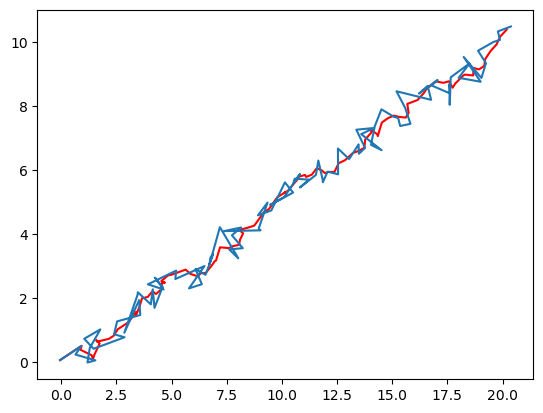

In [18]:
plt.plot(mu[:, 0], mu[:, 2], c = "r" ) # estimation 
plt.plot(zs[:, 0], zs[:, 1])

NOT WORKING FOR NOW :( 
## Extended Kalman Filter: 

### Predict:
We have: 
$$x_{k-1|k-1} \sim  \mathcal{N}(\hat{x}_{k-1|k-1}, \mathbf{P}_{k-1|k-1})$$
We approximate $x_{k|k-1}$ using first-order Taylor expansion: 
$$
\mathbf{x}_k = \mathbf{f}(\mathbf{x}_{k-1}) + \mathbf{q}_{k-1} \\
\approx \mathbf{f}(\hat{\mathbf{x}}_{k-1|k-1}) + \mathbf{f}'(\hat{\mathbf{x}}_{k-1|k-1}) \left( \mathbf{x}_{k-1} - \hat{\mathbf{x}}_{k-1|k-1} \right) + \mathbf{q}_{k-1}
$$
where  $\mathbf{f}'(\hat{\mathbf{x}}_{k-1|k-1})$ is the Jacobian matrix of the process function $\mathbf{f}(\mathbf{x}_{k-1})$<br>

**PREDICTION:**
$$
\hat{\mathbf{x}}_{k|k-1} = \mathbf{f}(\hat{\mathbf{x}}_{k-1|k-1}) $$
$$
\mathbf{P}_{k|k-1} = \mathbf{f}'(\hat{\mathbf{x}}_{k-1|k-1}) \mathbf{P}_{k-1|k-1} \mathbf{f}'(\hat{\mathbf{x}}_{k-1|k-1})^T + \mathbf{Q}_{k-1}
$$

### Update: 
Similarly, we approximate
$$
\mathbf{y}_k = \mathbf{h}(\mathbf{x}_k) + \mathbf{r}_k \\
\approx \mathbf{h}(\hat{\mathbf{x}}_{k|k-1}) + \mathbf{h}'(\hat{\mathbf{x}}_{k|k-1}) \left( \mathbf{x}_k - \hat{\mathbf{x}}_{k|k-1} \right) + \mathbf{r}_{k-1}
$$
**UPDATE:**
$$
\hat{\mathbf{x}}_{k|k} = \hat{\mathbf{x}}_{k|k-1} + \mathbf{K}_k \left( \mathbf{y}_k - \mathbf{h}(\hat{\mathbf{x}}_{k|k-1}) \right)$$
$$
\mathbf{P}_{k|k} = \mathbf{P}_{k|k-1} - \mathbf{K}_k \mathbf{S}_k \mathbf{K}_k^T$$ 
$$
\mathbf{S}_k = \mathbf{h}'(\hat{\mathbf{x}}_{k|k-1}) \mathbf{P}_{k|k-1} \mathbf{h}'(\hat{\mathbf{x}}_{k|k-1})^T + \mathbf{R}_k$$
$$
\mathbf{K}_k = \mathbf{P}_{k|k-1} \mathbf{h}'(\hat{\mathbf{x}}_{k|k-1})^T \mathbf{S}_k^{-1}
$$






In [19]:
from sympy import sin, cos, Matrix
from sympy.abc import rho, phi

In [37]:
# Jacobian example: 
X = Matrix([rho*cos(phi), rho*sin(phi), rho**2])
Y = Matrix([rho, phi])
a = X.jacobian(Y)
y = a.subs({rho: 1, phi: 1})
print(a) 
print(y)

Matrix([[cos(phi), -rho*sin(phi)], [sin(phi), rho*cos(phi)], [2*rho, 0]])
Matrix([[cos(1), -sin(1)], [sin(1), cos(1)], [2, 0]])


In [149]:
class Extended_Kalman_filter: 
    def __init__(self, f, Q, h, R, x, P, dt, B=None, u=None):
        self.f = f                                          # Process function
        self.B = B if B is not None else np.zeros_like(x)   # Control input matrix
        self.u = u if u is not None else np.zeros_like(x)   # Control input
        self.Q = Q                                          # Motion noise covariance
        self.h = h                                          # Observation function 
        self.R = R                                          # Measurement noise covariance 
        self.x = x                                          # Initial state
        self.P = P                                          # Error estimate covariance 
        self.dt = dt
        self.I = np.eye(len(self.x))
        self.state_history = [self.x]
        
        x_symbols = sp.Matrix(sp.symbols(f'x1:{len(self.x.flatten())+1}'))  # e.g., x1, x2, ..., xn
        print(x_symbols)
        x1, x2 = sp.symbols('x1 x2')
        h_symbolic = sp.Matrix([
            sp.sqrt((x_symbols[0] - pos_radar[0]) ** 2 + (x_symbols[1] - pos_radar[1]) ** 2),   # Distance
            sp.atan2(x_symbols[1] - pos_radar[1], x_symbols[0] - pos_radar[0]) * 180 / math.pi  # Angle in degrees
        ])
        self.F_jacobian_symbolic = sp.Matrix(f(x)).jacobian(x_symbols)
        self.H_jacobian_symbolic = h_symbolic.jacobian(x_symbols)
        print(self.H_jacobian_symbolic) 
        
    def compute_numerical_jacobian(self, jacobian_symbolic, x):
        x_r, y_r = sp.symbols('x_r y_r')
        # x has to be 4x1 np matrix
        subs_dict = {f'x{i+1}': x.flatten()[i] for i in range(x.size)} # dictionary of x
        subs_dict.update({x_r: 1, y_r: 1})                             # position of Radar 
        jacobian_numeric = np.array(jacobian_symbolic.subs(subs_dict).evalf()).astype(float)
        # print(jacobian_symbolic.subs(subs_dict))
        return jacobian_numeric

    def predict(self): 
        F = self.compute_numerical_jacobian(self.F_jacobian_symbolic, self.x)        
        self.x = self.f(self.x).reshape(4,1) 
        self.P = F @ self.P @ F.T + self.Q  # Covariance matrix update
        
    def update(self, z): 
        H = self.compute_numerical_jacobian(self.H_jacobian_symbolic, self.x)
        
        # Innovation covariance (S)
        S = np.array(H @ self.P @ H.T + self.R)
        S = np.array(S, dtype=np.float64)
        
        # Kalman gain (K)
        K = self.P @ H.T @ np.linalg.inv(S)
        K = np.array(K, dtype=np.float64)
        # print("dim of K", K.shape) 
        
        # Innovation (residual)
        # print("dim of self.h(self.x)", self.h(self.x).shape)
        y = z - np.array(self.h(self.x))
        # print("Dim of y", y.shape)
        
        # Update the state and covariance
        self.x = self.x + K @ y
        self.P = (self.I - K @ H) @ self.P
        
        # Store state history
        self.state_history.append(self.x.copy())
        # self.x = Matrix(self.x)
        # print("done")

### Example: Tracking a Airplane using Extended Kalman Filter
$$\mathbf x = \begin{bmatrix}\mathtt{distance} \\\mathtt{velocity}\\ \mathtt{altitude} \\ \mathtt{climb\, rate}\end{bmatrix}=  \begin{bmatrix}x \\\dot x\\ y \\ \dot y\end{bmatrix}$$

In [183]:
from numpy.linalg import norm # To calculate L2 norm
from math import atan2, degrees 
from math import sqrt
from numpy.random import randn 

In [413]:
# Incorporate both noisy reading and noisy velocity update. 
class radar(): 
    def __init__(self,
        dt = 1, 
        pos_radar = [0, 0], 
        vel = 1, 
        climb_rate = 0.1, 
        pos_AC = [100, 100], 
        vel_noise_std = 1,
        climb_rate_noise_std = 0.05,
        angle_std = 1, 
        distance_std = 1, 
    ): 
        self.dt = dt 
        self.pos_radar = np.array(pos_radar)
        self.pos_AC = pos_AC
        self.vel = vel 
        self.climb_rate = climb_rate
        self.vel_noise_std = vel_noise_std
        self.climb_rate_noise_std = climb_rate_noise_std
        self.angle_std = angle_std
        self.distance_std = distance_std
    def update(self): 
        self.pos_AC[0] += self.vel * self.dt + (self.vel * dt) * randn() * self.vel_noise_std
        self.pos_AC[1] += self.climb_rate * self.dt + (self.climb_rate * dt) * randn() * self.climb_rate_noise_std
    def read(self):
        self.update() 
        diff = np.subtract(self.pos_AC, self.pos_radar)
        # print(diff)
        distance = norm(diff) 
        angle = degrees(atan2(diff[1], diff[0]))
        return np.array([distance + randn() * self.distance_std, angle + randn() * self.angle_std]).reshape(2, 1)

In [279]:
r = radar() 
data = ([r.read() for _ in range(50)])

In [280]:
print(data)

[array([[140.40255799],
       [ 44.70639219]]), array([[143.89693221],
       [ 43.48417401]]), array([[144.41569224],
       [ 43.89457904]]), array([[145.12106968],
       [ 44.24020431]]), array([[144.13270205],
       [ 43.4938337 ]]), array([[146.7176142 ],
       [ 43.10847348]]), array([[146.44793518],
       [ 43.77344791]]), array([[148.54892105],
       [ 44.61780395]]), array([[148.24028805],
       [ 42.17155275]]), array([[150.49006706],
       [ 42.60857383]]), array([[150.69967915],
       [ 43.30809021]]), array([[150.94148424],
       [ 42.3299783 ]]), array([[150.93557302],
       [ 42.08660739]]), array([[153.2839598 ],
       [ 40.34753079]]), array([[154.15168063],
       [ 40.947826  ]]), array([[153.31708045],
       [ 41.07723148]]), array([[153.69895298],
       [ 40.2767471 ]]), array([[156.44078767],
       [ 40.61442032]]), array([[155.69744834],
       [ 39.76442452]]), array([[157.76775794],
       [ 37.76521634]]), array([[159.57011324],
       [ 40.2404

In [307]:
def process_function(x, dt):
    F = np.array([[1, dt, 0, 0],
                  [0,  1, 0, 0],
                  [0,  0, 1, dt],
                  [0,  0, 0, 1], 
                 ], dtype=float)
    return F @ x

In [308]:
pos_radar = [1, 1] 
def observation_function(x):
    #  x, y = sp.symbols('x1'), sp.symbols('x2')
    print(x)
    return sp.Matrix([
        sp.sqrt((x[0][0] - pos_radar[0]) ** 2 + (x[2][0] - pos_radar[1]) ** 2),  # Distance x
        sp.atan2(x[2][0] - pos_radar[1], x[0][0] - pos_radar[0]) * 180 / math.pi                                    # Angle in degrees
    ])
#x = [0, 0, 0, 0]
#x_symbols = sp.Matrix(sp.symbols(f'x1:{len(x)+1}'))  # e.g., x1, x2, ..., xn
#F_jacobian_symbolic = sp.Matrix(process_function(x_symbols)).jacobian(x_symbols)
#H_jacobian_symbolic = sp.Matrix(observation_function(x)).jacobian(x_symbols)
#print(H_jacobian_symbolic)

In [309]:
dt = 0.1 
q1 = Q_continuous_white_noise(dim = 2, dt = dt, spectral_density = 1) 
q2 = Q_continuous_white_noise(dim = 2, dt = dt, spectral_density = 0.1) 
Q = np.array(block_diag(q1, q2))
R = np.array([[1, 0], [0, 0.5]]) 
x_ = np.array([100, 1, 100, 1]).reshape(4,1)
P = np.eye(4)*500.

In [284]:
f = Extended_Kalman_filter(f = process_function, Q = Q, h = observation_function, R = R, x = x_, P = P, dt = dt, B = None, u = None,) 

Matrix([[x1], [x2], [x3], [x4]])
Matrix([[(x1 - 1)/sqrt((x1 - 1)**2 + (x2 - 1)**2), (x2 - 1)/sqrt((x1 - 1)**2 + (x2 - 1)**2), 0, 0], [57.2957795130823*(1 - x2)/((x1 - 1)**2 + (x2 - 1)**2), 57.2957795130823*(x1 - 1)/((x1 - 1)**2 + (x2 - 1)**2), 0, 0]])


In [285]:
for d in data: 
    f.predict() 
    f.update(d)

[[100.1]
 [  1. ]
 [100.1]
 [  1. ]]
[[100.195427456924]
 [0.969374432857191]
 [100.200000000000]
 [1.00000000000000]]
[[100.270548557586]
 [0.821922873798039]
 [100.300000000000]
 [1.00000000000000]]
[[100.337708894281]
 [0.719483467621907]
 [100.400000000000]
 [1.00000000000000]]
[[100.400468916662]
 [0.655676595826286]
 [100.500000000000]
 [1.00000000000000]]
[[100.443724529075]
 [0.504990874508712]
 [100.600000000000]
 [1.00000000000000]]
[[100.467113520078]
 [0.320940443225297]
 [100.700000000000]
 [1.00000000000000]]
[[100.482119967001]
 [0.203906330861486]
 [100.800000000000]
 [1.00000000000000]]
[[100.499980845870]
 [0.182801993736597]
 [100.900000000000]
 [1.00000000000000]]
[[100.475427959550]
 [-0.106767420468416]
 [101.000000000000]
 [1.00000000000000]]
[[100.429493153857]
 [-0.347052466649780]
 [101.100000000000]
 [1.00000000000000]]
[[100.369954640696]
 [-0.517933627802228]
 [101.200000000000]
 [1.00000000000000]]
[[100.276584572322]
 [-0.800546385856035]
 [101.3000000000

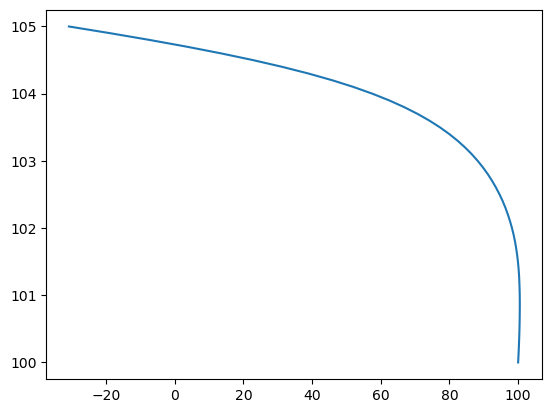

In [286]:
x_values = [f.state_history[i][0] for i in range(len(f.state_history))]
y_values = [f.state_history[i][2] for i in range(len(f.state_history))]
plt.plot(x_values, y_values)

## Unscented Kalman filter: 

**CHECKLIST** 
1. What is sigma points?
    Generating sigma points is a way to approximate the posterior distribution. <br> 
    Our prior follows some Gaussian distribution and instead of using Monte Carlo Sampling to approximate the posterior distribution which requires huge amount of computation, we pick a small number of points in our prior distribution. These points are designed to capture the mean and covariance of the prior distribution. We then pass them through the process function, we would achieve transformed sigma points, which will then be used to approximate the mean and the covariance of the posterior distribution. 
2. How can we use it to solve nonlinear problem? <br> 
    This solves nonlinear problem by approximate **the effects of a nonlinear function on a probablity distribution**.
3. How many sigma points should be generated? Why?
   The general rule is 2n + 1. <br>
   1 at the mean and two Points per Dimension to capture both the positive and negative deviation from the mean. <br>
    Total sigma points=1(mean point)+2(for each dimension)×n
   

### Predict: 
1. Generate sigma points (the points we use later to approximate the mean and covariance of a distrbution)  and their corresponding weights: 
$$\begin{aligned} 
\boldsymbol\chi &= \text{sigma-function}(\mathbf x, \mathbf P) \\
W^m, W^c &= \text{weight-function}(\mathtt{n, parameters})\end{aligned}$$
2. Pass each sigma point through the process function f, resulting the transformed sigma points $\boldsymbol{\mathcal{Y}}$:
$$\boldsymbol{\mathcal{Y}} = f(\boldsymbol{\chi}, \Delta t)$$        
3. Compute the predicted mean and covariance: 
$$\begin{aligned}
\mathbf{\bar x} &= \sum_{i=0}^{2n} w^m_i\boldsymbol{\mathcal Y}_i \\
\mathbf{\bar P} &= \sum_{i=0}^{2n} w^c_i({\boldsymbol{\mathcal Y}_i - \mathbf{\bar x})(\boldsymbol{\mathcal Y}_i-\mathbf{\bar x})^\mathsf{T}} + \mathbf Q
\end{aligned}
$$
### Update: 
1. Convert the transformed sigma points into measurements using a measurement function *h(x)*:
$$\boldsymbol{\mathcal{Z}} = h(\boldsymbol{\mathcal{Y}})$$
2. Compute the mean of $\boldsymbol{\mathcal{Z}}$
$$\begin{aligned}
\boldsymbol\mu_z &= \sum_{i=0}^{2n} w^m_i\boldsymbol{\mathcal Z}_i 
\end{aligned}$$
4. Compute the innovation:
$$\mathbf y = \mathbf z - \boldsymbol\mu_z $$
5. Compute the covariance of innovation:
$$\begin{aligned}
\mathbf P_z &= \sum_{i=0}^{2n} w^c_i{(\boldsymbol{\mathcal Z}_i-\boldsymbol{\mu}_z)(\boldsymbol{\mathcal Z}_i-\boldsymbol{\mu}_z)^\mathsf T} + \mathbf R
\end{aligned}
$$
6. Compute the Kalman gain:
We first compute the cross variance of the state and the measurements, which is defined as:
$$\mathbf P_{xz} =\sum_{i=0}^{2n} w^c_i(\boldsymbol{\mathcal Y}_i-\mathbf{\bar x})(\boldsymbol{\mathcal Z}_i-\boldsymbol\mu_z)^\mathsf T$$
And then Kalman gain is defined as: 
$$\mathbf{K} = \mathbf P_{xz} \mathbf P_z^{-1}$$
7. Update the state estimate and covariance:
$$
\mathbf{x} = \mathbf{\bar{x}} + \mathbf{K}\mathbf{y}
$$

$$
\mathbf{P} = (\mathbf{I} - \mathbf{K}\mathbf{H})\mathbf{\bar{P}}
$$


## Van der Merwe's Scaled Sigma Point Algorithm

**Parameters**: <br> 
* n: dimension of x <br> 
* $\alpha$: Scaling parameter. $0 \le \alpha \le 1$ is an appropriate choice for $\alpha$ <br> 
* $\beta$: incorporates prior knowledge of the distribution of the state. ($\beta = 2$ is optimal for Gaussian distribution). 
* $\kappa$: adjust the spread of the sigma points (is usually set at 3-n)

**Sigma points computation:** 
The first sigma point displayed is the mean of the input. <br>
$$ \mathcal{X}_0 = \mu$$
We define $\lambda = \alpha^2(n+\kappa)-n$. The remaining sigma points are computed as:
$$ 
\boldsymbol{\chi}_i = \begin{cases}
\mu + \left[ \sqrt{(n+\lambda)\Sigma}\right ]_{i}& i=1..n \\
\mu - \left[ \sqrt{(n+\lambda)\Sigma}\right]_{i-n} &i=(n+1)..2n\end{cases}
$$
**Weight computation:** 
The weight for the mean is computed as: 
$$W^m_0 = \frac{\lambda}{n+\lambda}$$
$$W^c_0 = \frac{\lambda}{n+\lambda} + 1 -\alpha^2 + \beta$$
The weights for the rest of the sigma points $\boldsymbol{\chi}_1 ... \boldsymbol{\chi}_{2n}$ are the same for the mean and covariance. They are

$$W^m_i = W^c_i = \frac{1}{2(n+\lambda)}\;\;\;i=1..2n$$

## Cubature sigma points: 
**Sigma points computation:** 
$$ 
\boldsymbol{\chi}_i = \begin{cases}
\mu + \left[ \sqrt{(n)}\mathbf{P}^{1/2}\right ]_{i}& i=1..n \\
\mu - \left[ \sqrt{(n)}\mathbf{P}^{1/2}\right]_{i-n} &i=(n+1)..2n\end{cases}
$$
where $\mathbf{P}^{1/2}$ is the  Cholesky decomposition of the covariance matrix $\mathbf{P}$ <br> 
**Cubature Weights**: 
The same for both mean and covariance: 
$$w_i^{mean} = w_i^{cov} = \frac{1}{2n}$$

### Example: Tracking a Airplane using Unscented Kalman Filter
$$\mathbf x = \begin{bmatrix}\mathtt{distance} \\\mathtt{velocity}\\ \mathtt{altitude} \\ \mathtt{climb\, rate}\end{bmatrix}=  \begin{bmatrix}x \\\dot x\\ y \\ \dot y\end{bmatrix}$$

In [390]:
from filterpy.kalman import unscented_transform, MerweScaledSigmaPoints
from filterpy.kalman import UnscentedKalmanFilter

In [425]:
r = radar(dt = 1, 
        pos_radar = [0, 0], 
        vel = 1, 
        climb_rate = 0.1, 
        pos_AC = [100, 100], 
        vel_noise_std = 1,
        climb_rate_noise_std = 0.05,
        angle_std = 1, 
        distance_std = 1
         ) 
data = [r.read() for _ in range(500)]

In [432]:
data_ = np.array([data[i].flatten() for i in range(len(data))])

In [434]:
data_.shape

(500, 2)

In [435]:
points = MerweScaledSigmaPoints(n=4, alpha=.1, beta=2., kappa=-1)
points

MerweScaledSigmaPoints object
n = 4
alpha = 0.1
beta = 2.0
kappa = -1
Wm = [-132.33333333   16.66666667   16.66666667   16.66666667   16.66666667
        16.66666667   16.66666667   16.66666667   16.66666667]
Wc = [-129.34333333   16.66666667   16.66666667   16.66666667   16.66666667
        16.66666667   16.66666667   16.66666667   16.66666667]
subtract = <ufunc 'subtract'>
sqrt = <function cholesky at 0x1382040e0>

In [436]:
def process_function(x, dt):
    F = np.array([[1, dt, 0, 0],
                  [0,  1, 0, 0],
                  [0,  0, 1, dt],
                  [0,  0, 0, 1], 
                 ], dtype=float)
    return F @ x

In [437]:
pos_radar = [1, 1] 
def observation_function(x):
    #  x, y = sp.symbols('x1'), sp.symbols('x2')
    print(x)
    return np.array([
        sqrt((x[0] - pos_radar[0]) ** 2 + (x[2] - pos_radar[1]) ** 2),                                     # Distance x
        atan2(x[2] - pos_radar[1], x[0] - pos_radar[0]) * 180 / math.pi                                    # Angle in degrees
    ])

In [438]:
# Using the same data above: 
points = MerweScaledSigmaPoints(n=4, alpha=.1, beta=2., kappa=-1)
kf = UnscentedKalmanFilter(dim_x=4, dim_z=2, dt=dt, fx=process_function, hx=observation_function, points=points)
kf.Q = Q
kf.R = R 
kf.x = np.array([100, 1, 100, 1]).T
kf.P = np.eye(4)*500.
print(kf.x.shape)

(4,)


In [439]:
(mu, cov, *_) = kf.batch_filter(data_)  

[100.1   1.  100.1   1. ]
[103.97298335   1.         100.1          1.        ]
[100.48729833   4.87298335 100.1          1.        ]
[100.1          1.         103.97298335   1.        ]
[100.1          1.         100.48729833   4.87298335]
[ 96.22701665   1.         100.1          1.        ]
[ 99.71270167  -2.87298335 100.1          1.        ]
[100.1          1.          96.22701665   1.        ]
[100.1          1.          99.71270167  -2.87298335]
[102.76396214   1.25133049  98.75515953   0.85840766]
[103.16604765   1.29123942  98.91651941   0.87342093]
[103.14937692   5.10547829  98.75505392   0.85839741]
[102.76396214   1.25133049  99.12339786   0.89503249]
[102.76396214   1.25133049  99.14053962   4.71220854]
[102.36187663   1.21142156  98.59379964   0.84339439]
[102.37854736  -2.60281732  98.75526514   0.85841791]
[102.76396214   1.25133049  98.38692119   0.82178282]
[102.76396214   1.25133049  98.36977944  -2.99539322]
[103.00725373   0.3073075  101.74822971  10.4756938 ]
[1

In [440]:
mu

array([[ 1.02638829e+02,  1.25133049e+00,  9.86693188e+01,
         8.58407660e-01],
       [ 1.02976523e+02,  3.07307504e-01,  1.00700660e+02,
         1.04756938e+01],
       [ 1.02446769e+02, -3.69091809e+00,  1.01277091e+02,
         6.97600983e+00],
       ...,
       [ 6.00798096e+02,  1.00814178e+01,  1.50039675e+02,
         1.15834059e+00],
       [ 6.01626736e+02,  9.90792812e+00,  1.50352914e+02,
         1.20742838e+00],
       [ 6.02697699e+02,  9.88391933e+00,  1.49950586e+02,
         1.06877431e+00]])

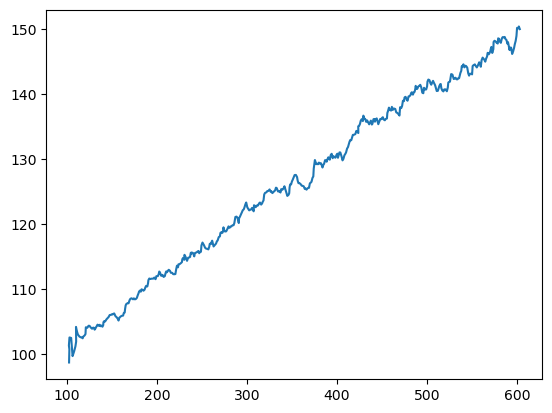

In [447]:
plt.plot(mu[:, 0], mu[:, 2]) 
# SHOULD BE CORRECT 

## Bearing (sensors updated with different rates)  
**Basically store data as multiple stacks and pop it until no more data left**

A system: <br>
1. 2 sensors, each updated with different data rates. Let say sensor 1 is updated at 4Hz and sensor 2 is updated at 8hz <br>
2. Observations include the bearing of 2 sensors to the objects<br>
3. For simplicity: Our object is moving in straight line with constant velocity<br>

In [748]:
from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.kalman import UnscentedKalmanFilter as UKF
import math
from numpy.random import randn

In [749]:
sensor_A_pos = [0, 0] 
sensor_B_pos = [400, 0]
# What should the meas
def bearing_1(x, sensor):       # For generating the data 
    return atan2(x[1]-sensor[1], x[0]-sensor[0]) # return in radians 
def bearing_2(x, sensor):       # For generating the data 
    return atan2(x[2]-sensor[1], x[0]-sensor[0]) # return in radians 
def measurement_function_1(x):  # For generating the data 
    return [bearing_1(x, sensor_A_pos), bearing_1(x, sensor_B_pos)] 
def measurement_function_2(x):  # For passing to the filter 
    return [bearing_2(x, sensor_A_pos), bearing_2(x, sensor_B_pos)] 

In [750]:
data_ = []
def gen_sensor_data(initial_pos, intital_vel, t, sensor_A_std, sensor_B_std, data_to_plot):
    # generate simulated sensor data
    sensor_data_A, sensor_data_B = [], []
    pos_A = initial_pos.copy()
    pos_B = initial_pos.copy()
    dt = 0.
    for i in range(t*3):
        dt += 1/3
        pos_A[1] += intital_vel * 1/4 + randn() * sensor_A_std
        pos_A[0] += + randn() * sensor_A_std
        t_i = dt + randn() * .001
        data_to_plot.append(pos_A.copy())
        sensor_data_A.append([t_i, measurement_function_1(pos_A.copy())])
    dt = 0.    
    for i in range(t*7):
        dt += 1/7
        pos_B[1] += intital_vel * 1/8 + randn() * sensor_B_std
        pos_B[0] += + randn() * sensor_B_std
        t_i = dt + randn() * .0006
        data_to_plot.append(pos_B.copy())
        sensor_data_B.append([t_i, measurement_function_1(pos_B.copy())])
    return sensor_data_A, sensor_data_B

In [751]:
initial_pos = [200., 100.] 
intital_vel = 1.
(data_A, data_B)  = gen_sensor_data(initial_pos, intital_vel, t = 300, sensor_A_std = 0.001, sensor_B_std = 0.006, data_to_plot = data_)

In [752]:
data_

[[200.00003808447528, 100.25010797207834],
 [199.99998286281345, 100.50028001293676],
 [200.00012425929282, 100.75019567210065],
 [200.0000818988835, 101.00006692519443],
 [200.00018629724448, 101.25009400724687],
 [200.00010615157277, 101.50021821250591],
 [200.00010576957905, 101.75031614091289],
 [199.99999790276027, 102.00041192107385],
 [200.00005049725573, 102.25050400838242],
 [200.00008357135175, 102.50074204420456],
 [200.00009964007347, 102.75086219216479],
 [200.00016609776796, 103.00079541384108],
 [200.00018894751145, 103.25076900168627],
 [200.00025467254784, 103.5006809127173],
 [200.0001634938137, 103.75067282466217],
 [200.00013902818063, 104.00069229087755],
 [200.00026065775785, 104.25072006566953],
 [200.0001567133535, 104.50071323358986],
 [200.00015048178778, 104.75066989770124],
 [200.0002583794428, 105.00060503885655],
 [200.00035045795892, 105.2507227743249],
 [200.00028058829557, 105.50088746283872],
 [200.00023960811455, 105.75094309000659],
 [200.00033047723

In [753]:
def fx_(x,dt): 
    x[0] += x[1] * dt
    x[2] += x[3] * dt
    return x

In [754]:
points = MerweScaledSigmaPoints(n=4, alpha=.1, beta=2., kappa=-1)
kf = UnscentedKalmanFilter(dim_x=4, dim_z=2, dt=dt, fx=fx_, hx=measurement_function_2, points=points)
std_noise = 0.1 
kf.Q = Q
kf.R *= std_noise**2
kf.u = 0.
kf.x = np.array([200, 0, 100, 0])
kf.P = np.eye(4)*10.

In [755]:
last_t = 0
xs = []
while len(data_A) > 0 and len(data_B) > 0: 
    if data_A[0][0] < data_B[0][0]:
        t, z = data_A.pop(0) 
    else: 
        t, z = data_B.pop(0) 
        
    dt = t - last_t 
    last_t = t
    kf.dt = dt
    q = Q_continuous_white_noise(dim = 2, dt = dt, spectral_density = 0.1) 
    kf.Q = np.array(block_diag(q, q))
    
    def fx_wrapper(x):
        return fx_(x, dt)
    kf.f = fx_wrapper

    kf.f = fx_(kf.x, dt) 
    # print(z)
    kf.predict()
    kf.update(z)
    xs.append(kf.x) 

In [756]:
data_to_plot = np.asarray(data_)
xs = np.asarray(xs)

In [757]:
xs

array([[ 1.99999999e+02, -1.42502448e-07,  1.00004036e+02,
         5.51479830e-04],
       [ 1.99999999e+02, -6.48610914e-08,  1.00012193e+02,
         2.67817101e-03],
       [ 2.00000000e+02,  6.58402331e-08,  1.00021232e+02,
         5.69623586e-03],
       ...,
       [ 2.00002456e+02, -6.33529024e-06,  3.50441916e+02,
         3.36386362e-01],
       [ 2.00002374e+02, -1.44940613e-05,  3.50793298e+02,
         3.56292360e-01],
       [ 2.00002292e+02, -2.28165101e-05,  3.51091381e+02,
         3.75777513e-01]])

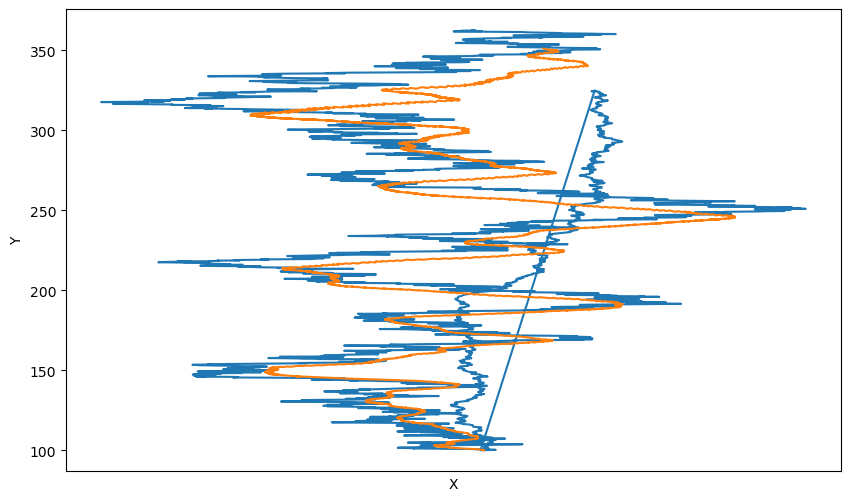

In [758]:
plt.figure(figsize=(10,6))
xs = np.asarray(xs)
plt.xlabel('X')
plt.ylabel('Y')
x_min = min(data_to_plot[:, 0].min(), xs[:, 0].min())
x_max = max(data_to_plot[:, 0].max(), xs[:, 0].max())
plt.xticks(np.arange(int(x_min), int(x_max) + 1, 50))  
plt.plot(data_to_plot[:, 0], data_to_plot[:, 1])
plt.plot(xs[:, 0], xs[:, 2])

## 3D to 2D projection 
### Using pinhole camera model 


In [1350]:
import numpy as np

def uv_to_bearing_elevation(u, v, horizontal_fov, vertical_fov):
    """
    Convert UV coordinates to bearing and elevation angles.
    
    Args:
        u (float): Horizontal coordinate (0 to 1, left to right)
        v (float): Vertical coordinate (0 to 1, top to bottom)
        horizontal_fov (float): Horizontal field of view in degrees
        vertical_fov (float): Vertical field of view in degrees
        
    Returns:
        tuple: (bearing, elevation) in degrees
        - bearing: angle in horizontal plane (-180 to +180)
        - elevation: angle in vertical plane (-90 to +90)
    """
    # Convert UV from [0,1] to [-1,1] range
    u = (u * 2) - 1
    v = (v * 2) - 1
    
    # Calculate the tangent of half the FOV
    tan_half_hfov = np.tan(np.radians(horizontal_fov / 2))
    tan_half_vfov = np.tan(np.radians(vertical_fov / 2))
    
    # Calculate 3D vector
    x = u * tan_half_hfov
    y = -v * tan_half_vfov  # Negative because v increases downward
    z = 1.0  # Forward direction
    
    # Calculate bearing (azimuth) angle
    bearing = np.degrees(np.arctan2(x, z))
    
    # Calculate elevation angle
    elevation = np.degrees(np.arctan2(y, np.sqrt(x*x + z*z)))
    
    return bearing, elevation

# Example usage with test points
if __name__ == "__main__":
    # Test points
    test_points = [
        (0.5, 0.5, "Center"),
        (0.0, 0.5, "Left edge"),
        (1.0, 0.5, "Right edge"),
        (0.5, 0.0, "Top edge"),
        (0.5, 1.0, "Bottom edge"),
    ]
    
    # Example camera FOV
    h_fov = 90  # degrees
    v_fov = 60  # degrees
    
    print(f"Camera FOV: {h_fov}° horizontal, {v_fov}° vertical")
    print("\nTest points:")
    
    for u, v, description in test_points:
        bearing, elevation = uv_to_bearing_elevation(u, v, h_fov, v_fov)
        print(f"\n{description}:")
        print(f"UV coordinates: ({u:.2f}, {v:.2f})")
        print(f"Bearing: {bearing:.1f}°, Elevation: {elevation:.1f}°")
        if abs(bearing) > 90:
            print("Point is BEHIND the camera")
        else:
            print("Point is IN FRONT of the camera")

Camera FOV: 90° horizontal, 60° vertical

Test points:

Center:
UV coordinates: (0.50, 0.50)
Bearing: 0.0°, Elevation: -0.0°
Point is IN FRONT of the camera

Left edge:
UV coordinates: (0.00, 0.50)
Bearing: -45.0°, Elevation: -0.0°
Point is IN FRONT of the camera

Right edge:
UV coordinates: (1.00, 0.50)
Bearing: 45.0°, Elevation: -0.0°
Point is IN FRONT of the camera

Top edge:
UV coordinates: (0.50, 0.00)
Bearing: 0.0°, Elevation: 30.0°
Point is IN FRONT of the camera

Bottom edge:
UV coordinates: (0.50, 1.00)
Bearing: 0.0°, Elevation: -30.0°
Point is IN FRONT of the camera


## Our system: 
1. For simplicity, a linear system with constant velocity.
3. Both camera coordinates and object coordinates are the same.
4. No distortion and rotation of the image plane.
5. The measurement model: Not using the (u,v) coordinates on the image plane but converting things into bearing and elevation to determine whether the object is behind or in front of the camera.
* Bearing angles between -90 and +90: FRONT
* Bearing angles between <-90 and >+90: BEHIND <br>
-> Converting into absolute value to implement. <br>
### To implement the linear camera observation model, converting into homogeneous coordinates: 
* Since no distortion and rotation:
$$
P' = MP = 
\begin{bmatrix} 
\alpha & 0 & c_x \\ 
0 & \beta & c_y \\ 
0 & 0 & 1 
\end{bmatrix} 
\begin{bmatrix} 
I & 0 
\end{bmatrix} 
P = K 
\begin{bmatrix} 
I & 0 
\end{bmatrix} 
P$$
$$P = \begin{bmatrix} 
    x \\
    y \\ 
    z \\ 
    1 
\end{bmatrix}$$

In [1558]:
# In the x-axis, 10 pixels = 1cm
#k = 1/10
# In the y-axis, 10 pixels = 1cm
#l = 1/10

#f = 800 # in cm
#alpha = k * f
#beta = l * f 
# The digital image plane is (800 * 800) pixels 
#c_x = 400 
#c_y = 400 
#K = np.array([[alpha, 0, c_x],
#              [0, beta, c_y], 
#              [0, 0, 1]]) 
#M = K @ np.array([[1, 0, 0, 0],
#                 [0, 1, 0, 0], 
#                 [0, 0, 1, 0]]) 
#vel = np.array([1, 1, 1]) 

In [1653]:
#std_noise = 0.1
#f_x, f_y  = 800, 800
#dt = 1 

#def hx(x):
#    X = x[0]
#    Y = x[2]
#    Z = x[4]
#    u = f_x * (X / Z)
#    v = f_y * (Y / Z)
#    return np.array([u, v])
def fx(x, dt): 
    x[0] += x[1] * dt
    x[2] += x[3] * dt
    x[4] += x[5] * dt
    return x
#def measurement(target_pos, c_x, c_y): 
#    x = target_pos[0] 
#    y = target_pos[1] 
#    z = target_pos[2] 
#    u = f_x * (x / z) + c_x 
#    v = f_y * (y / z) + c_y 
#    return [u, v]
def bearing_elevation(x): 
    bearing = np.degrees(np.arctan2(x[0], x[4]))
    elevation = np.degrees(np.arctan2(x[2], np.sqrt(x[0]**2 + x[4]**2)))
    return [bearing, elevation] 

In [1654]:
def gen_data(initial_pos, N, vel, dt, noise_std): 
    exact_pos, measurements = [], []
    for i in range(N): 
        initial_pos[0] += vel[0] * dt + randn() * noise_std
        initial_pos[1] += vel[1] * dt + randn() * noise_std
        initial_pos[2] += vel[2] * dt + randn() * noise_std
        exact_pos.append([initial_pos[0], initial_pos[1], initial_pos[2]]) 
        z = [np.degrees(np.arctan2(initial_pos[0], initial_pos[2])), 
             np.degrees(np.arctan2(initial_pos[1], np.sqrt(initial_pos[0]**2 + initial_pos[2]**2)))] + np.random.normal(0, std_noise , size=2)
        measurements.append(z)
    return exact_pos, measurements 

In [1655]:
initial_pos = [100, 200, 100]
vel = np.array([1, 1, -0.5]) 
pos, txs = gen_data(initial_pos, 500, vel, 1, 0.01)

In [1656]:
txs

[array([45.52860335, 54.76058605]),
 array([45.86192384, 54.83978369]),
 array([46.24837691, 54.85446412]),
 array([46.72568704, 54.88332234]),
 array([47.14138827, 55.08940424]),
 array([47.55195484, 55.11277215]),
 array([48.22231588, 55.29676359]),
 array([48.21577245, 55.1142293 ]),
 array([48.76373716, 55.15324453]),
 array([49.26622306, 55.4109142 ]),
 array([49.60030085, 55.38294519]),
 array([49.90644202, 55.37186933]),
 array([50.43308635, 55.30416326]),
 array([50.69767175, 55.53371364]),
 array([51.30910324, 55.522252  ]),
 array([51.46374879, 55.61765304]),
 array([52.02866183, 55.45370253]),
 array([52.42883883, 55.75021357]),
 array([52.57511078, 55.79703793]),
 array([53.21640945, 55.80578785]),
 array([53.48954744, 55.85173921]),
 array([53.80057291, 55.7641363 ]),
 array([54.44109938, 55.66456788]),
 array([54.7034518 , 55.91777835]),
 array([54.89828238, 55.86725267]),
 array([55.31244246, 55.76319638]),
 array([55.61865849, 55.81465165]),
 array([56.05798087, 55.9778

In [1657]:
pos

[[101.02118951291995, 200.99516072157326, 99.50681020332831],
 [102.0231632263661, 201.97532419932253, 99.02608765434684],
 [103.00933367171659, 202.9688808871672, 98.55063327163357],
 [104.00382331676809, 203.9397501517847, 98.05000932949972],
 [105.00646384488911, 204.94242892999802, 97.51536123802573],
 [105.99689038702833, 205.9498809694973, 97.0036540538186],
 [107.00685941450675, 206.95550293669982, 96.50092912402415],
 [107.99719703042764, 207.95283707304222, 95.9995246745531],
 [109.00377309290793, 208.95355651505704, 95.48736799758515],
 [109.9982825978571, 209.98212260028066, 94.98982411120053],
 [111.00038708395533, 210.98389278383414, 94.49627166511863],
 [111.99938976287301, 211.9790402183327, 93.97954273669158],
 [112.99724402273159, 212.9910757588559, 93.48213356101742],
 [113.9951938481924, 213.98116894609632, 92.99971260848143],
 [115.02242854614911, 214.98568686078744, 92.46754607338086],
 [116.00715105350864, 215.98690296545723, 91.97418705552195],
 [117.010903775561

In [1664]:
points = MerweScaledSigmaPoints(n=6, alpha=0.1, beta=2.0, kappa=-3)
kf = UKF(dim_x=6, dim_z=2, fx=fx, hx=bearing_elevation, points=points, dt=1)
kf.x = np.array([70, 0, 150, 0, 80, 0]).T
kf.u = 0.
kf.Q *= 5.
# q = Q_continuous_white_noise(dim = 3, dt = dt, spectral_density = 0.01) 
kf.Q[1][1] = 0.
kf.Q[3][3] = 0.
kf.Q[5][5] = 0.
kf.R *= 0.4
kf.P *= 10.

In [1665]:
xs = []
for i in range(len(txs)): 
    if abs(txs[i][0]) <= 90: 
        kf.predict()
        kf.update(txs[i]) 
        print("real pos", pos[i]) 
        print("x", kf.x) 
        print("estimated pos", [kf.x[0], kf.x[2], kf.x[4]]) 
        xs.append(kf.x) 

real pos [101.02118951 200.99516072  99.5068102 ]
x [ 7.55173943e+01  2.75869717e+00  1.50167303e+02  8.36517218e-02
  7.48585675e+01 -2.57071627e+00]
estimated pos [75.51739434117239, 150.1673034435365, 74.8585674674116]
real pos [102.02316323 201.9753242   99.02608765]
x [ 76.55480588   1.94446086 150.93051863   0.34154544  73.95834549
  -1.81869734]
estimated pos [76.55480587513289, 150.93051862579324, 73.958345485493]
real pos [103.00933367 202.96888089  98.55063327]
x [ 77.15358012   1.49607907 151.35810534   0.36778739  73.50647261
  -1.36404432]
estimated pos [77.15358011846885, 151.358105343441, 73.50647261120722]
real pos [104.00382332 203.93975015  98.05000933]
x [ 77.80033273   1.28272821 151.71939662   0.36766013  72.99053828
  -1.14894339]
estimated pos [77.80033272642336, 151.71939662135293, 72.99053828304231]
real pos [105.00646384 204.94242893  97.51536124]
x [ 78.17980636   1.10020683 152.36523989   0.42379333  72.32638329
  -1.05122856]
estimated pos [78.1798063568207

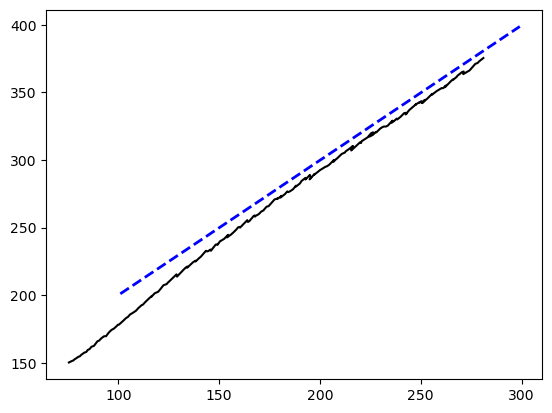

In [1666]:
### PLOT X-axis vs Y-axis 
xs = np.asarray(xs)
pos = np.asarray(pos)
plt.plot(xs[:, 0], xs[:, 2], color = "black")
mask = pos[:, 2] >= 0
filtered_pos = pos[mask]
plt.plot(filtered_pos[:, 0], filtered_pos[:, 1], ls='--', lw=2, color='blue')
plt.show() 
# Definely need some more tuning. 

# Multiple object tracking
- Implement a scenario with a fixed number of targets (2D to begin) and fixed number of sensors
- Generate measurements from each sensor for each target (measurements = number of sensors * number of targets)
- Compute the assignment scores using Mahalanobis distance of the "predicted measurements"
            $$D_M = \sqrt{(\mathbf{x} - \boldsymbol{\mu})^\top \mathbf{S}^{-1} (\mathbf{x} - \boldsymbol{\mu})}$$
- Run the hungarian algorithm on the assignment scores to assign measurements to targets
- Update the targets with the assigned measurements


## Hungarian algorithm: 
**Step 1**: Suctract row minnima  <br>  
**Step 2**: Subtract column minima <br>  
**Step 3**: Cover all zeros with a minimum number of lines <br>
If less than n lines are required, continue with Step 4. 
If n lines are required, an optimal assignment exits among the zeros. Stop!! <br>  
**Step 4**: Find the smallest element (k) that is not covered by all the lines in step 3. <br>  Subtract k from all uncovered elements, and add k to all elements that 

In [2]:
from scipy.optimize import linear_sum_assignment

In [1164]:
cost = np.array([[4, 1, 3], [2, 0, 5], [3, 2, 2]])
row_ind, col_ind = linear_sum_assignment(cost)
print(col_ind) 

[1 0 2]


1. Generate measurements from each sensor for each target (measurements = number of sensors * number of targets)
2. For each sensor, compute the assignment scores using Mahalanobis distance of the "predicted measurements"
3. For each sensor, Run the hungarian algorithm on the assignment scores to assign measurements to targets
4. Design the H matrix to match the number of sensors.    

# Mahalanobis distance
$$D_m= \sqrt{(\mathbf x-\mu)^\mathsf T \mathbf S^{-1} (\mathbf x-\mu)}$$

In [1185]:
from filterpy.stats import mahalanobis

For simplicity, each target is moving with a constant velocity. 

In [1320]:
def gen_sensor_measurement(N, number_of_sensors, number_of_targets, initial_pos, noise_std, vel, dt): 
    res = []
    initial_pos_ = initial_pos
    sensor_measurements = [initial_pos.copy() for _ in range(number_of_sensors)]
    for i in range(N):  
        for j in range(number_of_sensors):  
            for k in range(number_of_targets): 
                # print(initial_pos_) 
                sensor_measurements[j][k][0] += dt * vel[k][0] + noise_std[j] * randn()
                sensor_measurements[j][k][1] += dt * vel[k][1] + noise_std[j] * randn()
                # print(sensor_measurements)
        res.append([sensor.copy() for sensor in sensor_measurements])  
        # print(res) 
    return res

In [1321]:
N = 100
n = 2         # 2 sensors
N_targets = 3 # 3 targets
initial_pos = np.array([[5., 0.], [10., 0.], [15., 0.]])
noise_std = [0.1, 0.05] 
vel = np.array([[1., 1.], [0., 1.], [0.5, -1.]])
dt  = 1
data = gen_sensor_measurement(N = N, 
                              number_of_sensors = n, 
                              number_of_targets = N_targets, 
                              initial_pos = initial_pos, 
                              noise_std = noise_std, 
                              vel = vel, 
                              dt = dt)

In [1322]:
data

[[array([[ 5.96724061,  1.07452511],
         [ 9.84639102,  1.10894328],
         [15.48756952, -0.85468845]]),
  array([[ 5.95485779,  0.90936061],
         [ 9.99855266,  1.0293538 ],
         [15.53354685, -1.05677441]])],
 [array([[ 6.8047773 ,  2.04329271],
         [ 9.89803542,  2.15552196],
         [16.14478215, -1.89203397]]),
  array([[ 6.86261297,  1.96919394],
         [10.00831243,  2.0434632 ],
         [16.07190137, -1.99359223]])],
 [array([[ 7.80247531,  3.16094788],
         [ 9.95324904,  3.08996372],
         [16.62145831, -2.83035957]]),
  array([[ 7.82717173,  3.01351689],
         [10.0162216 ,  3.06254411],
         [16.64392663, -2.97576388]])],
 [array([[ 8.80961649,  4.15268903],
         [ 9.93978335,  4.12119366],
         [17.2577906 , -3.8915372 ]]),
  array([[ 8.79279887,  4.07776889],
         [ 9.98791426,  4.07334885],
         [17.11433676, -4.05973811]])],
 [array([[ 9.82943901,  5.26420582],
         [ 9.93357786,  4.9730278 ],
         [17.76869

In [1323]:
q = Q_continuous_white_noise(dim = 2, dt = dt, spectral_density = 0.5) 

In [1324]:
def trackingSystem(n, dt_): 
    """ 
    Parameters:
    - n (int): Number of targets
    Returns: 
    - tracker(list): KF objects
    """ 
    tracker = [KalmanFilter(dim_x = 4, dim_z = 4) for i in range(n)]
    for i in range(n): 
        tracker[i].F = np.array([[1, dt_, 0, 0], 
                        [0, 1, 0, 0], 
                        [0, 0, 1, dt_], 
                         [0, 0, 0, 1]])
        tracker[i].Q = block_diag(q, q) 
        tracker[i].u = 0.
        tracker[i].H = np.array([[1, 0, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0, 0, 1, 0]])
        tracker[i].R *= 0.01
        tracker[i].x = np.array([0, 0, 0, 0]).T
        tracker[i].P = np.eye(4)*500.
    return tracker     

In [1325]:
tracker = trackingSystem(N_targets, 1)  

In [1326]:
"""
1. Generate measurements from each sensor for each target (measurements = number of sensors * number of targets)
2. For each sensor, compute the assignment scores using Mahalanobis distance of the "predicted measurements"
3. For each sensor, Run the hungarian algorithm on the assignment scores to assign measurements to targets
4. Design the H matrix to match the number of sensors.    
"""
indices = [0, 2]
xs = []
for i in range(N): # Number of iterations 
    target_mahalanobis = []
    for j in range(n): # Number of sensors
        target_mahalanobis_each_sensor = []
        for k in range(N_targets): # Number of targets 
            tracker[k].predict() 
            # print(data[i][j][k]) 
            # print(tracker[k].x)
            # print(tracker[i].P) 
        cost_matrix = np.zeros((N_targets, N_targets))
        for track_idx in range(N_targets): 
            for det_idx in range(N_targets): 
                mean = [tracker[track_idx].x[0], tracker[track_idx].x[2]]
                cov = tracker[track_idx].P[np.ix_(indices, indices)]
                cost_matrix[track_idx][det_idx] = mahalanobis(x=data[i][j][det_idx], 
                                                mean=mean, 
                                                cov=cov)
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        for track_idx, det_idx in zip(row_ind, col_ind):
            target_mahalanobis_each_sensor.append(data[i][j][det_idx])
        target_mahalanobis.append(target_mahalanobis_each_sensor)
    # print(target_mahalanobis)  
    xs_each_target = []
    for id in range(N_targets): 
        # print(target_mahalanobis[0][id])
        tracker[id].update(np.concatenate((target_mahalanobis[0][id], target_mahalanobis[1][id]), axis=0))
        xs_each_target.append(tracker[id].x)
    xs.append(xs_each_target) 

In [1330]:
xs = np.asarray(xs)
data = np.asarray(data)

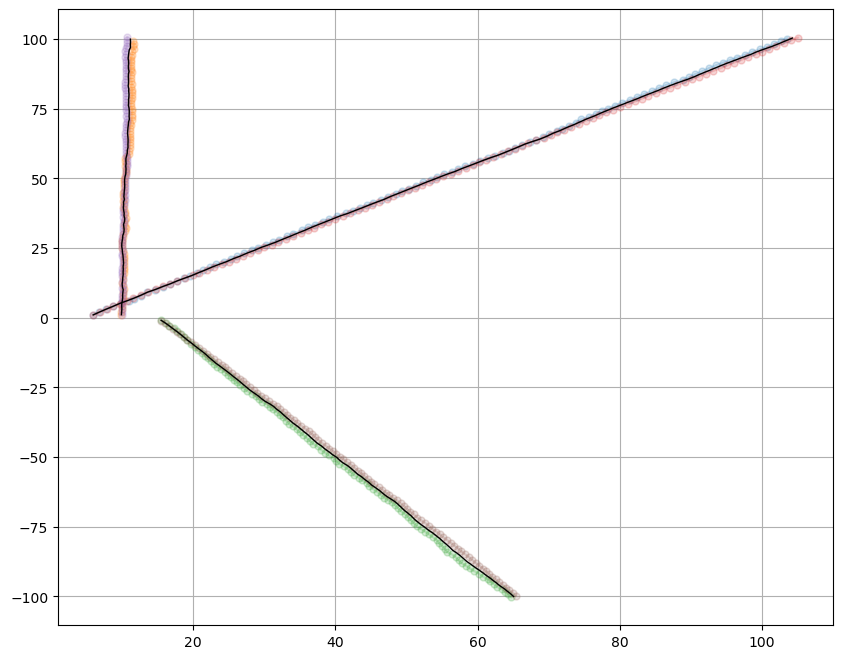

In [1349]:
plt.figure(figsize=(10, 8))
for i in range(n):
    for j in range(N_targets):
         plt.plot(data[:, i, j, 0], data[:, i, j, 1], marker='o', markersize=5, alpha = 0.2)
for i in range(N_targets):
    plt.plot(xs[:, i, 0], xs[:, i, 2], linewidth=1, color = "black") 
plt.grid(True)